## ARIMA Models (Core)
* Load this Walmart stock data.    (source)
* We will use data from 2010 to 2020 to predict the  Adjusted Close values for the next quarter.
* Make a datetime index using the Date column with a business day frequency ('B')
* Check for and address null values.
* Check the time series for stationarity.
    * Determine the number of differencing (d) needed to make the data stationary. (We recommend using pmdarima's ndiffs)
* Use ACF/PACF plots of the stationary data to estimate initial time series model orders (p,d,q)
* Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days)
* Fit an ARIMA model based on the orders determined during your exploration.
    * Make forecasts with your model.
    * Plot the forecasts versus the test data.
    * Obtain metrics for evaluation.
* Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)
* A MAPE of less than 2% on the test data is achievable.
* Choose a final model and explain:
    * How good was your model, according to your Mean Absolute Percentage Error?
    * How good was your model in terms of how well the forecast seems to follow the test data, visually?  (Hint: You may want to plot fewer training data lags to see this)

### Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

### Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

### Load Data

In [6]:
# Load in stock data
ts = pd.read_csv("Data/WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


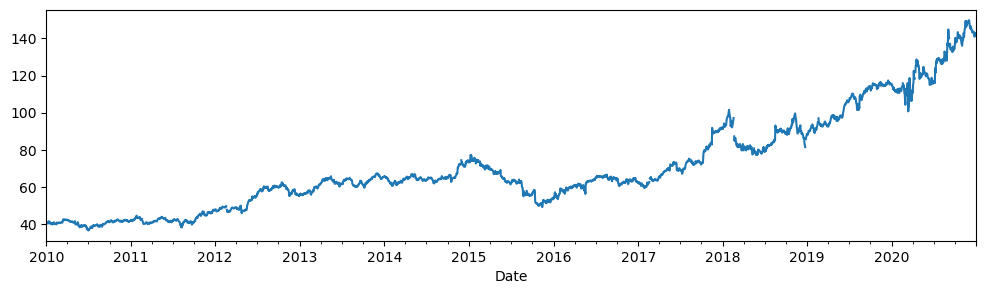

In [7]:
# Filter for 2010-2020 and only the adj close value
ts = ts.loc['2010':'2020', 'Adj Close']
ts.plot();

In [8]:
# Preview the index
ts.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=2870, freq=None)

In [9]:
# Resample for business day with 'B'
ts = ts.resample('B').asfreq()
ts

Date
2010-01-01           NaN
2010-01-04     40.963638
2010-01-05     40.555729
2010-01-06     40.465084
2010-01-07     40.487759
                 ...    
2020-12-25           NaN
2020-12-28    142.946777
2020-12-29    142.041183
2020-12-30    141.923065
2020-12-31    141.893524
Freq: B, Name: Adj Close, Length: 2870, dtype: float64

In [10]:
# Check for nulls
ts.isna().sum()

101

In [11]:
# Inspect null values
null = ts.isna()
ts[null].head(20)

Date
2010-01-01   NaN
2010-01-18   NaN
2010-02-15   NaN
2010-04-02   NaN
2010-05-31   NaN
2010-07-05   NaN
2010-09-06   NaN
2010-11-25   NaN
2010-12-24   NaN
2011-01-17   NaN
2011-02-21   NaN
2011-04-22   NaN
2011-05-30   NaN
2011-07-04   NaN
2011-09-05   NaN
2011-11-24   NaN
2011-12-26   NaN
2012-01-02   NaN
2012-01-16   NaN
2012-02-20   NaN
Name: Adj Close, dtype: float64

The null values correspond with US holidays.Therefore, we have to fill in the missing values with the previous value.

We will use fillna() with method='ffill' (forward fill).

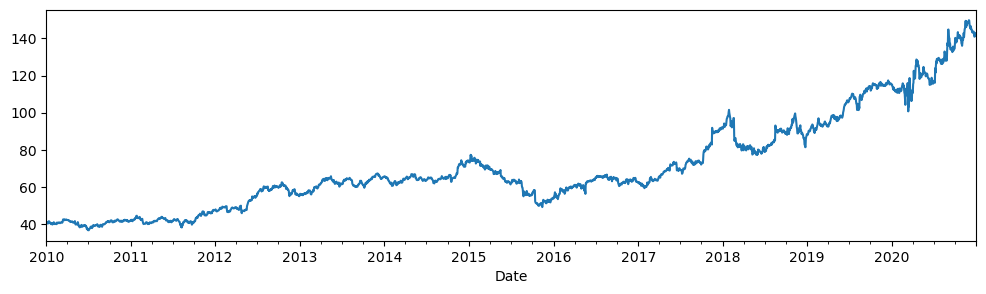

In [12]:
# Fill missing values with previous value
ts = ts.fillna(method='ffill')
ts.plot();

In [13]:
# Check for nulls if still exist
ts.isna().sum()

1

In [14]:
# Apply backward fill to ensure the first row is filled as well
ts = ts.fillna(method='bfill')

In [15]:
# Finally, check for any remaining nulls
remaining_nulls = ts.isna().sum()
remaining_nulls

0

In [16]:
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.457375,23,2846,0.99736,0.05,False


The raw data is not stationary. Will use ndiffs to determine differencing.

In [17]:
# use ndiffs to determine differencing
d = ndiffs(ts)
print(f'd is {d}')

d is 1


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.211384,22,2846,0.0,0.05,True


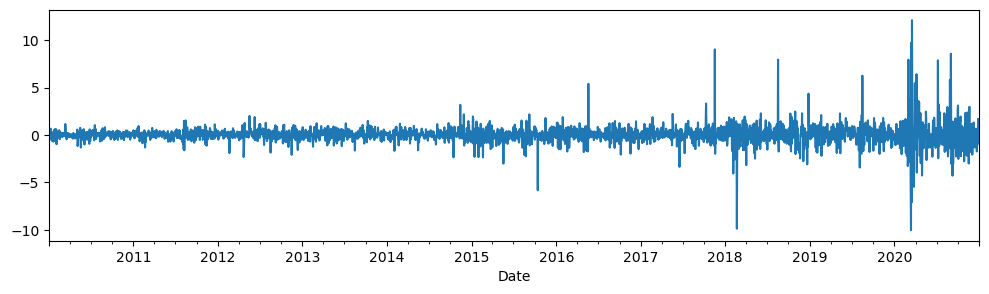

In [18]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

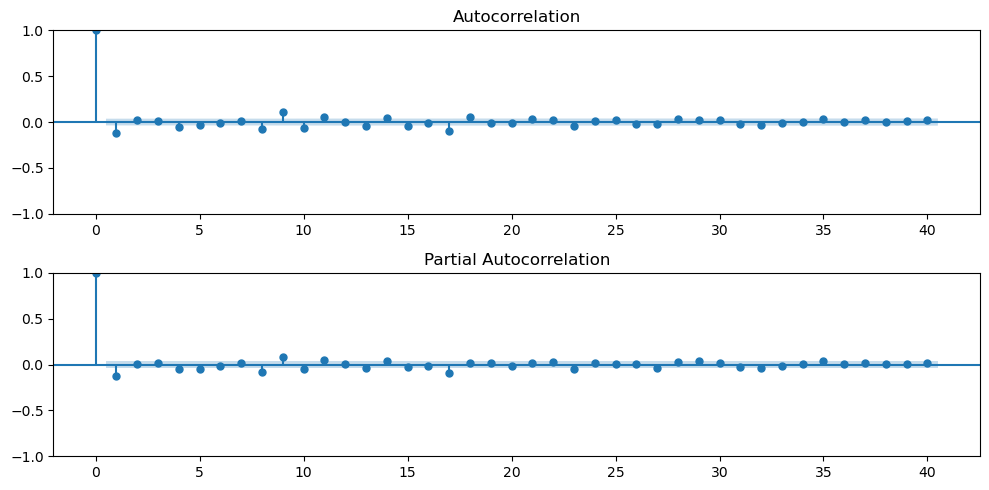

In [19]:
# Use differenced (stationary) data to plot ACF and PACF
plot_acf_pacf(ts_diff);

Interpretation:

* Both the PACF and the ACF plots shows a sharp cut-off after lag 0.
* The plots suggets an ARIMA (0,1,0) model.

### Train Test Split

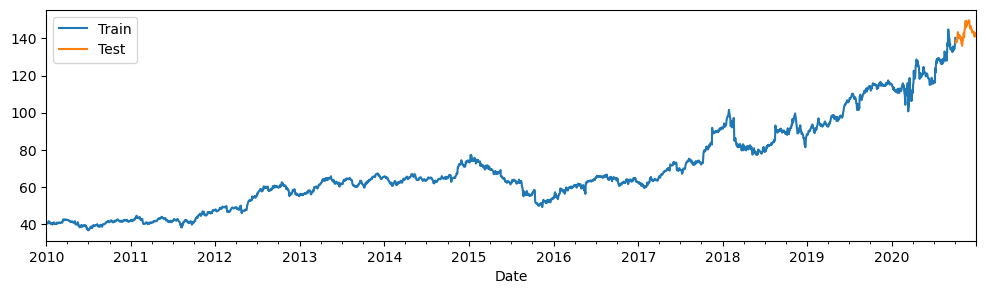

In [20]:
# Calculating number of test lags
n_test_lags = 5*13

# Modeling to predict one quarter into the future
train, test = train_test_split(ts, test_size=n_test_lags)

# Visualize the train test split
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

#### Fit and Evaluate

In [21]:
# Fit an ARIMA model, using the model orders (p,d,q) determined based on EDA, (0,1,0)
# Build the model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q = 0 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

#### Model Summary and Diagnostics Plots

In [22]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3908.604
Date:                Tue, 02 Apr 2024   AIC                           7819.208
Time:                        11:46:09   BIC                           7825.147
Sample:                    01-01-2010   HQIC                          7821.352
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9512      0.006    158.428      0.000       0.939       0.963
===================================================================================
Ljung-Box (L1) (Q):                  40.70   Jarque-Bera (JB):            133511.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.78   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

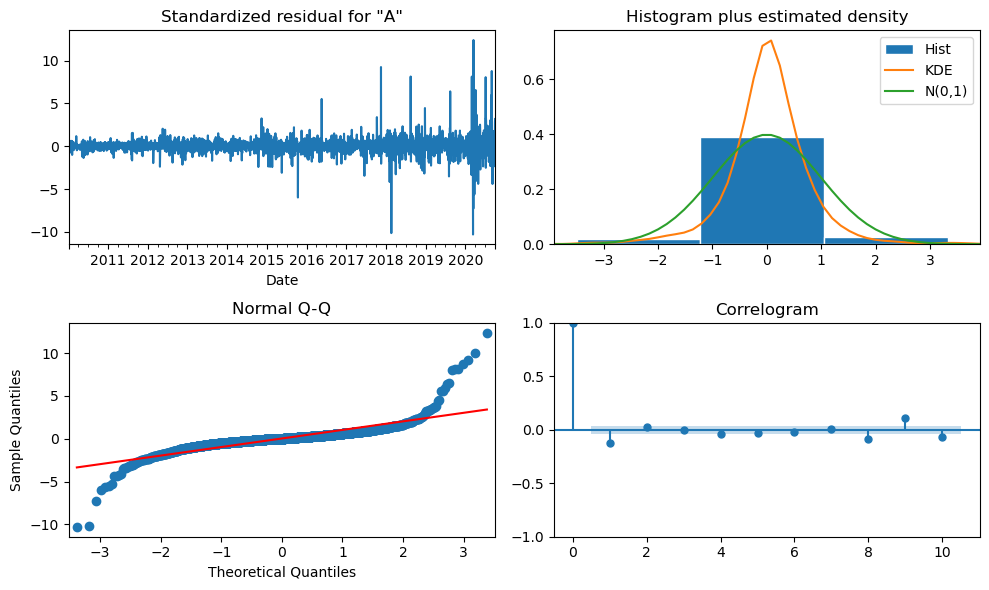

In [23]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

#### Make forecasts with your model

In [24]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

#### Plot the forecasts versus the test data

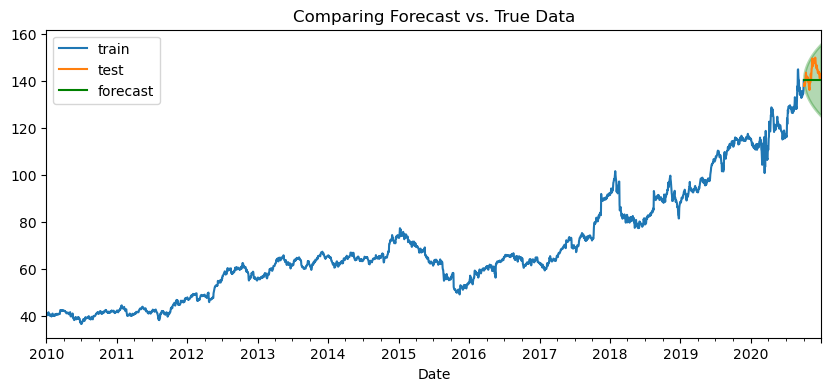

In [27]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df);

#### Obtain metrics for evaluation

In [28]:
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.578
- MSE = 20.594
- RMSE = 4.538
- R^2 = -0.601
- MAPE = 2.46%


#### Try at least one variation of the model for comparison 
(we recommend using a loop to try combinations of model orders)

In [31]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [32]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7819.208494266164
(0, 1, 1) 7782.259464241215
(0, 1, 2) 7782.92906576815
(1, 1, 0) 7781.098108389092
(1, 1, 1) 7782.920211106092
(1, 1, 2) 7783.719076364093
(2, 1, 0) 7782.903746036738
(2, 1, 1) 7785.078171014683


C:\Users\bandi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bandi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7785.080820008997
Best AIC: 7781.098108389092
Best pdq: (1, 1, 0)


#### How good was your model, according to your Mean Absolute Percentage Error?

A MAPE of 2.46% suggests that on average, the model's predictions are off by 2.46% from the actual values. It indicates a high level of accuracy and suggests that the model is performing well.

#### How good was your model in terms of how well the forecast seems to follow the test data, visually?

Based on the plot, the ARIMA(0,1,0) model's forecast captures the upward trend of the test data quite well, visually aligning with the actual observed values.

The ARIMA(1,1,0) is the preferable model due to its lowest AIC value. 
This suggests some improvement over the ARIMA(0,1,0) model predicted manually.

Considering the MAPE and the AIC criteria, the ARIMA(1,1,0) model appears to be a best fit.